In [187]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# PROTOTYPE

### Objectives

- Extract data from csv files to put in an appropriate data structure
- Build a network and find shortest path

In [188]:
streams = pd.read_csv("test_cases/example_streams.csv",
                      names=['PCP','StreamName','StreamType','SourceNode','DestinationNode','Size','Period','Deadline']
                     )
topology_cols = [str(i) for i in range(7)]
topology = pd.read_csv("test_cases/simple_topology.csv",names=topology_cols).groupby('0')

In [189]:
switches = topology.get_group('SW')
switches = switches.drop(columns=['4','5','6'])
switches.columns = ['DeviceType','DeviceName','Ports','Domain']

end_systems = topology.get_group('ES')
end_systems = end_systems.drop(columns=['4','5','6'])
end_systems.columns = ['DeviceType','DeviceName','Ports','Domain']

links = topology.get_group('LINK')
links.columns = ['LINK','LinkID','SourceDevice','SourcePort','DestinationDevice','DestinationPort','Domain']

In [190]:
end_systems.head()

,DeviceType,DeviceName,Ports,Domain
3,ES,ES_0,1,0.0
4,ES,ES_1,1,0.0
5,ES,ES_2,1,0.0
6,ES,ES_3,1,0.0


In [191]:
switches.head()

,DeviceType,DeviceName,Ports,Domain
0,SW,SW_0,8,0.0
1,SW,SW_1,8,0.0
2,SW,SW_2,8,0.0


In [192]:
links.head()

,LINK,LinkID,SourceDevice,SourcePort,DestinationDevice,DestinationPort,Domain
7,LINK,Link_1,SW_0,NaN,SW_1,NaN,0.0
8,LINK,Link_2,SW_0,NaN,SW_2,NaN,0.0
9,LINK,Link_3,SW_0,3.0,ES_0,1.0,0.0
10,LINK,Link_4,SW_0,NaN,ES_1,NaN,0.0
11,LINK,Link_5,SW_1,NaN,SW_2,NaN,0.0


In [205]:
G = nx.MultiGraph()
# multi graph to allow multiple links between two same nodes

# this creates the links as well as the necessary nodes
for link in links.iterrows():
    source = link[1]['SourceDevice']
    destination = link[1]['DestinationDevice']
    source_port = link[1]['SourcePort']
    destination_port = link[1]['DestinationPort']
    G.add_edge(source,
               destination,
               source_port=source_port,
               destination_port=destination_port
              )

for end_system in end_systems.iterrows():
    name = end_system[1]['DeviceName']
    G.nodes[name]['ports'] = end_system[1]['Ports']

for switch in switches.iterrows():
    name = switch[1]['DeviceName']
    G.nodes[name]['ports'] = switch[1]['Ports']

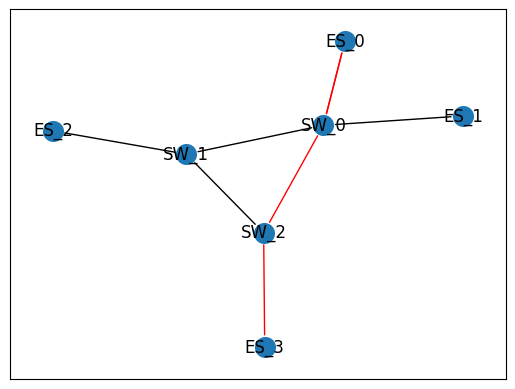

In [206]:
path = nx.shortest_path(G, "ES_0", "ES_3")
# Create a list of edges in the shortest path
path_edges = list(zip(path, path[1:]))

# Create a list of all edges, and assign colors based on whether they are in the shortest path or not
edge_colors = [
    "red" if edge in path_edges or tuple(reversed(edge)) in path_edges else "black"
    for edge in G.edges()
]

# Visualize the graph
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 200)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors)
nx.draw_networkx_labels(G, pos)

plt.show()

In [207]:
G.nodes.get('SW_0')

{'ports': '8'}

In [210]:
G.edges.get(['SW_0', 'ES_0', 0])

{'source_port': 3.0, 'destination_port': 1.0}

In [212]:
G.edges.items()

ItemsView(MultiEdgeView([('SW_0', 'SW_1', 0), ('SW_0', 'SW_2', 0), ('SW_0', 'ES_0', 0), ('SW_0', 'ES_0', 1), ('SW_0', 'ES_1', 0), ('SW_1', 'SW_2', 0), ('SW_1', 'ES_2', 0), ('SW_2', 'ES_3', 0)]))